In [1]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns

In [2]:
with open(r"C:\Users\juans\github\juan_analysis\20201210\intermediates\unit_times_dataframe.pkl", 'rb') as z:
    units_df = pkl.load(z)
       
with open(r"C:\Users\juans\github\juan_analysis\20201210\intermediates\gratori_all_df.pkl", 'rb') as z:
    gratori_data = pkl.load(z)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\juans\\github\\juan_analysis\\20201210\\intermediates\\unit_times_dataframe.pkl'

In [ ]:
gratori_data.head()

In [ ]:
imec0_units = units_df.loc[units_df['probe']=='imec0']
imec0_units.reset_index(inplace = True, drop = True)

imec1_units = units_df.loc[units_df['probe']=='imec1']
imec1_units.reset_index(inplace = True, drop = True)

In [5]:
def psth_line(times,triggers,pre=0.5,timeDomain=True,post=1,binsize=0.05,ymax=75,yoffset=0,output='fig',name='',color='#00cc00',linewidth=0.5,axes=None,labels=True,sparse=False,labelsize=18,axis_labelsize=20,error='shaded',alpha=0.5,**kwargs):
    post = post + 1
    peris=[]#np.zeros(len(triggers),len(times))
    p=[]
    if timeDomain:
        samplingRate = 1.0
    else:
        samplingRate = samplingRate
        
    times = np.array(times).astype(float) / samplingRate
    triggers = np.array(triggers).astype(float) / samplingRate

    numbins = int((post+pre) / binsize) 
    bytrial = np.zeros((len(triggers),numbins))
    for i,t in enumerate(triggers):
        
        if len(np.where(times >= t - pre)[0]) > 0 and len(np.where(times >= t + post)[0]) > 0:
            start = np.where(times >= t - pre)[0][0]
            end = np.where(times >= t + post)[0][0]
            for trial_spike in times[start:end-1]:
                if float(trial_spike-t)/float(binsize) < float(numbins):
                    bytrial[i][int((trial_spike-t)/binsize-1)] +=1   
        else:
        	 pass
             #bytrial[i][:]=0
        #print 'start: ' + str(start)+'   end: ' + str(end)

    variance = np.std(bytrial,axis=0)/binsize/np.sqrt((len(triggers)))
    hist = np.mean(bytrial,axis=0)/binsize
    edges = np.linspace(-pre+binsize,post+binsize,numbins)
    return variance,hist,edges

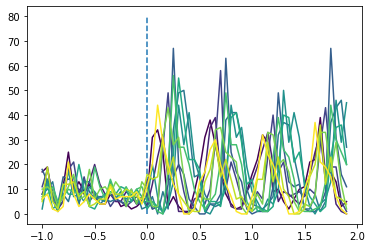

In [103]:
data1 = imec0_units; data = pd.DataFrame(data1.reset_index(drop = True))
stim_data = gratori_data; condition='ori'
unit = 42; times = np.array(data.times[unit])
pre = 1; post=2; binsize=0.05
numbins = int((post+pre) / binsize)
x = np.arange(-pre,post,binsize)
colors = plt.cm.viridis(np.linspace(0,1,11))

fig,ax = plt.subplots()

for i,cond in enumerate(np.unique(stim_data[condition])):
    triggers = np.array(stim_data['times'][stim_data[condition] == cond])
    bytrial = np.zeros((len(triggers),numbins-1))
    for j, trigger in enumerate(triggers):
        trial = triggers[j]
        start = trial-pre
        end = trial+post
        bins_ = np.arange(start,end,binsize)
        trial_spikes = times[np.logical_and(times>=start, times<=end)]
        hist,edges = np.histogram(trial_spikes,bins=bins_)
        if len(hist)==59:
            bytrial[j]=hist
    psth = np.mean(bytrial,axis=0)/binsize
    ax.plot(x[:-1],psth, color=colors[i])
plt.vlines(x=0,linestyles='dashed',ymin=0,ymax=80)

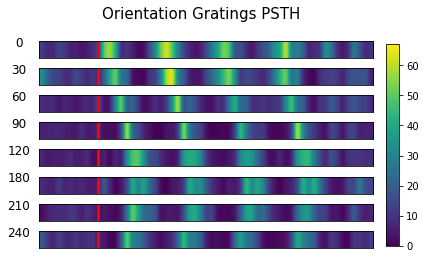

In [165]:
data1 = imec0_units; data = pd.DataFrame(data1.reset_index(drop = True))
stim_data = gratori_data; condition='ori'
unit = 42; times = np.array(data.times[unit])
pre = 0.5; post=2.5; binsize=0.05
numbins = int((post+pre) / binsize)
#x = np.round(np.arange(-pre,post,binsize).astype(float),1)

fig,ax = plt.subplots(8,1)
psth_all = []

for i,cond in enumerate(np.unique(stim_data[condition])[:8]):
    triggers = np.array(stim_data['times'][stim_data[condition] == cond])
    bytrial = np.zeros((len(triggers),numbins-1))
    for j, trigger in enumerate(triggers):
        trial = triggers[j]
        start = trial-pre
        end = trial+post
        bins_ = np.arange(start,end,binsize)
        trial_spikes = times[np.logical_and(times>=start, times<=end)]
        hist,edges = np.histogram(trial_spikes,bins=bins_)
        if len(hist)==59:
            bytrial[j]=hist
    psth = np.mean(bytrial,axis=0)/binsize
    psth = np.reshape(psth,(1,len(psth)))
    psth_all.append(psth)
    im = ax[i].imshow(psth,aspect=3, vmin=0,vmax=np.max(psth_all),interpolation='gaussian')
    ax[i].set_ylabel(str(cond),rotation=0,labelpad=20,fontsize=12)
    ax[i].set_yticks([])
    ax[i].axvline(pre/binsize,color='r',linewidth=3)
    #if i == len(np.unique(stim_data[condition])[:8])-1:
        #ax[i].set_xticks([0,pre/binsize+binsize,(pre+post)/binsize+binsize])
        #ax[i].set_xticklabels([-pre,0,post])
    #else:
        #ax[i].set_xticks([])
    ax[i].set_xticks([])
#fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0)
cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
fig.suptitle('Orientation Gratings PSTH', fontsize=15)
fig.colorbar(im,cax=cbar_ax )
#plt.vlines(x=0,linestyles='dashed',ymin=0,ymax=80)
plt.show()

In [ ]:
def psth_summary(spiketimes, stim_data, unit, title='', pre=0.5, post=2.5, binsize=0.05, color='viridis',interp=True):
    times = np.array(spiketimes.times[unit]); numbins = int((post+pre) / binsize)
    conditions = np.unique(stim_data[condition])
    
    fig,ax = plt.subplots(len(conditions),1)
    psth_all = []

    for i,cond in enumerate(conditions[:8]):
        triggers = np.array(stim_data['times'][stim_data[condition] == cond])
        bytrial = np.zeros((len(triggers),numbins-1))
        for j, trigger in enumerate(triggers):
            trial = triggers[j]
            start = trial-pre
            end = trial+post
            bins_ = np.arange(start,end,binsize)
            trial_spikes = times[np.logical_and(times>=start, times<=end)]
            hist,edges = np.histogram(trial_spikes,bins=bins_)
            if len(hist)==59:
                bytrial[j]=hist
        psth = np.mean(bytrial,axis=0)/binsize
        psth = np.reshape(psth,(1,len(psth)))
        psth_all.append(psth)
        im = ax[i].imshow(psth,aspect=3, vmin=0,vmax=np.max(psth_all),interpolation='gaussian')
        ax[i].set_ylabel(str(cond),rotation=0,labelpad=20,fontsize=12)
        ax[i].set_yticks([])
        ax[i].axvline(pre/binsize,color='r',linewidth=3)
        #if i == len(np.unique(stim_data[condition])[:8])-1:
            #ax[i].set_xticks([0,pre/binsize+binsize,(pre+post)/binsize+binsize])
            #ax[i].set_xticklabels([-pre,0,post])
        #else:
            #ax[i].set_xticks([])
        ax[i].set_xticks([])
    #fig.tight_layout()
    fig.subplots_adjust(hspace=0,wspace=0)
    cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
    fig.suptitle('Orientation Gratings PSTH', fontsize=15)
    fig.colorbar(im,cax=cbar_ax )
    #plt.vlines(x=0,linestyles='dashed',ymin=0,ymax=80)
    plt.show()